# Driver fatigue detection through multiple entropy fusion analysis in an EEG-based system

- - - -
- Primjenjeno istraživanje - pratimo stanje vozača kako bi detektirali umor i spriječili nesreće. Kao nekakav krajnji rezultat želimo napraviti uređaji koji će to moći detektirati u realnom vremenu.
- Primarno istraživanje - podatci su sakupljani izravno od vozača koji su sudjelovali u istraživanju vozeći na simulatoru.
- Laboratorijsko istraživanje - podatci su prikupljani izravno sa simulatora na kojemu su bili vozači.
- Kvantitativno istraživanje - numerički podatci koji predstavlju očitanje rada ljudskog mozga u digitalnom obliku.
- Promatračko i opisno istraživanje - istraživači nisu utjecali na vozače, samo su očitavali podatke sa simulatora i obrađivali ih dok su ispitanici nesmetano vozili na simulatoru.
- Deduktivno istraživanje - temeljem očitanih podataka i obradom istih želimo zaključiti je li vozač umoran ili nije pri vožnji.
- Podatci su prikupljani metodom eksperimenta jer je bilo unaprijed određeno vrijeme vožnje u normalnom stanju i u stanju umora kako bi se moglo pratiti ponašanje mozga baš u tim uvjetima.
- Studija presjeka - svi ispitanici su bili promatrani u točnom određenom vremenu u istom vremenskom periodu.
- Podatci su prikupljani i objavljeni prema pravilima istraživačke etike jer su svi ispitanici dobrovoljno pristali na sudjelovanje, a njihovi osobni podatci su uklonjeni iz skupa podataka i anonimizirani kako se ne bi mogli povezati s ispitanicima.
- - - -
- Applied research - we monitor the condition of drivers to detect fatigue and prevent accidents. As a result, we want to make devices that will be able to detect this in real time.
- Primary research - data were collected directly from drivers who participated in the research driving on a simulator.
- Laboratory research - data were collected directly from the simulator on which the drivers were.
- Quantitative research - numerical data that represent the reading of the human brain in digital form.
- Observational and descriptive research - the researchers did not influence the drivers, they only read the data from the simulator and processed it while the respondents drove smoothly on the simulator.
- Deductive research - based on the read data and processing them, we want to conclude whether the driver is tired or not while driving.
- Data were collected by the method of experiment because there was a predetermined driving time in the normal state and in the state of fatigue in order to be able to monitor the behavior of the brain in these conditions.
- Cross-sectional study - all subjects were observed at a specific time in the same time period.
- Data were collected and published according to the rules of research ethics because all respondents voluntarily agreed to participate, and their personal data were removed from the data set and anonymized so that they could not be linked to respondents.
- - - -

# Classifiers and training

Import required libraries.

In [1]:
import time
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as clfrep
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

Load previously calculated entropies from files.

In [2]:
AE_normal_matrix = np.load("data/AE_normal_matrix.npy")
PE_normal_matrix = np.load("data/PE_normal_matrix.npy")
SE_normal_matrix = np.load("data/SE_normal_matrix.npy")
FE_normal_matrix = np.load("data/FE_normal_matrix.npy")

AE_fatigue_matrix = np.load("data/AE_fatigue_matrix.npy")
PE_fatigue_matrix = np.load("data/PE_fatigue_matrix.npy")
SE_fatigue_matrix = np.load("data/SE_fatigue_matrix.npy")
FE_fatigue_matrix = np.load("data/FE_fatigue_matrix.npy")

ENTROPIES = [
    [AE_normal_matrix, AE_fatigue_matrix], 
    [PE_normal_matrix, PE_fatigue_matrix], 
    [SE_normal_matrix, SE_fatigue_matrix], 
    [FE_normal_matrix, FE_fatigue_matrix]
]

ENTROPIES_NAMES = ["AE", "PE", "SE", "FE"]

num_entropies = 4
num_people = 12
num_epochs = 300
num_channels = 30

Clean NaN and infinity values from dataset.

In [3]:
for i in range(len(ENTROPIES)):
    for j in range(len(ENTROPIES[i])):
        for k in range(num_people):
            avg_for_person = np.nanmean(ENTROPIES[i][j][k])
            np.nan_to_num(ENTROPIES[i][j][k], copy=False, nan=avg_for_person, posinf=avg_for_person, neginf=avg_for_person)

Generate dataset X using selected people. `train_index` contains indexes of people that will be used when creating the dataset.

In [4]:
def get_all_X(train_index):
    matrix_X = np.zeros(shape=(num_entropies, 2*num_epochs, num_channels))

    for person in train_index:
        for entropy in range(num_entropies):
            normal_X = np.zeros(shape=(num_epochs, num_channels))
            for ch in range(num_channels):
                for epoch in range(num_epochs):
                    normal_X[epoch][ch] = (ENTROPIES[entropy][0][person][epoch][ch][0])
            fatigue_X = np.zeros(shape=(num_epochs, num_channels))
            for ch in range(num_channels):
                for epoch in range(num_epochs):
                    fatigue_X[epoch][ch] = (ENTROPIES[entropy][1][person][epoch][ch][0])
                  
            # scale <-1, 1>
            scaler = StandardScaler()
            normal_scaled_X = scaler.fit_transform(normal_X)
            fatigue_scaled_X = scaler.fit_transform(fatigue_X)
            
            X = np.concatenate((normal_scaled_X, fatigue_scaled_X), axis=0)
            matrix_X[entropy] = X
        person_X = np.concatenate((matrix_X[0], matrix_X[1], matrix_X[2], matrix_X[3]), axis=1)
        if person == train_index[0]:
            matrix_all_X = person_X
        else:
            matrix_all_X = np.concatenate((matrix_all_X, person_X), axis=0)
        
    return matrix_all_X

Generate dataset y label using selected people. ```train_index``` contains indexes of people that will be used when creating the dataset.

In [5]:
def get_all_y(train_index):
    normal = list()
    fatigue = list()
    for epoch in range(num_epochs):
        normal.append(1)
    for epoch in range(num_epochs):
        fatigue.append(0)
    person_y = np.concatenate((normal, fatigue), axis=0)
            
    for person in train_index:
        if person == train_index[0]:
            people_y = person_y
        else:
            people_y = np.concatenate((people_y, person_y), axis=0)
            
    return people_y

Create subsets for multiple entropy. E.g.: (0, 1), (0, 2), (1, 2) ...

In [6]:
def create_subset(arr, r):
    return list(combinations(arr, r))

Split dataset 1:1 (50% / 50%) for training and testing. This dataset will be used in MLP, Random forest and K-neighbors classifiers.

In [7]:
people_indexes = [i for i in range(num_people)]

X = get_all_X(train_index=people_indexes)
y = get_all_y(train_index=people_indexes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## MLP

In [8]:
clf = MLPClassifier(activation="logistic", hidden_layer_sizes=20, max_iter=500)
clf.fit(X_train, y_train)
clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f"MLP score: {score}")

MLP score: 0.7525


/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Random forest

In [9]:
clf = RandomForestClassifier(n_estimators=500, max_features=22)
clf.fit(X_train, y_train)
clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f"RandomForest score: {score}")

RandomForest score: 0.9941666666666666


## K-neighbors

In [10]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
neigh.predict(X_test)
score = neigh.score(X_test, y_test)
print(f"K-neighbors score: {score}")

K-neighbors score: 0.7252777777777778


## SVM

### SVM using single entropy

In [11]:
# train model for each entropy
for entropy in range(num_entropies):
    for person in range(num_people):
        normal_X = np.zeros(shape=(num_epochs, num_channels))
        for ch in range(num_channels):
            for epoch in range(num_epochs):
                normal_X[epoch][ch] = (ENTROPIES[entropy][0][person][epoch][ch][0])
        fatigue_X = np.zeros(shape=(num_epochs, num_channels))
        for ch in range(num_channels):
            for epoch in range(num_epochs):
                fatigue_X[epoch][ch] = (ENTROPIES[entropy][1][person][epoch][ch][0])

        # scale <-1, 1>
        scaler = StandardScaler()
        normal_scaled_X = scaler.fit_transform(normal_X)
        fatigue_scaled_X = scaler.fit_transform(fatigue_X)
        
        X = np.concatenate((normal_scaled_X, fatigue_scaled_X), axis=0)
        if person == 0:
            all_X = X
        else:
            all_X = np.concatenate((all_X, X), axis=0)
           
    X = np.array(all_X)
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
    
    # train model
    svc = SVC(gamma=2**(-5), C=2**(-1), kernel="rbf")
    model = svc.fit(X_train, y_train)
    h = model.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=h)
    clfrep_score = clfrep(y_true=y_test, y_pred=h)
    
    print(f"Entropy {ENTROPIES_NAMES[entropy]}")
    print(f"Score: {score}")
    print(clfrep_score)

Entropy AE
Score: 0.6811111111111111
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1812
           1       0.68      0.69      0.68      1788

    accuracy                           0.68      3600
   macro avg       0.68      0.68      0.68      3600
weighted avg       0.68      0.68      0.68      3600

Entropy PE
Score: 0.6663888888888889
              precision    recall  f1-score   support

           0       0.68      0.65      0.66      1812
           1       0.66      0.68      0.67      1788

    accuracy                           0.67      3600
   macro avg       0.67      0.67      0.67      3600
weighted avg       0.67      0.67      0.67      3600

Entropy SE
Score: 0.6738888888888889
              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1812
           1       0.65      0.73      0.69      1788

    accuracy                           0.67      3600
   macro avg     

### SVM using two types of entropies

In [12]:
entropies_index_arr = [i for i in range(num_entropies)]
r = 2

entropy_subset_2 = create_subset(entropies_index_arr, r)
num_entropies_subsets = len(entropy_subset_2)
assert(num_entropies_subsets == 6)

entropy_subset_2_X = list()
entropy_X = np.zeros(shape=(num_people, 2 * num_epochs, 2 * num_channels))


# create entropy subsets
for entropy in entropy_subset_2:
    i = 0
    for person in range(num_people):
        normal_X1 = np.zeros(shape=(num_epochs, num_channels))    
        normal_X2 = np.zeros(shape=(num_epochs, num_channels))        
        for ch in range(num_channels):
            for epoch in range(num_epochs):
                normal_X1[epoch][ch] = (ENTROPIES[entropy[0]][0][person][epoch][ch][0])
                normal_X2[epoch][ch] = (ENTROPIES[entropy[1]][0][person][epoch][ch][0])                
        fatigue_X1 = np.zeros(shape=(num_epochs, num_channels))
        fatigue_X2 = np.zeros(shape=(num_epochs, num_channels))
        for ch in range(num_channels):
            for epoch in range(num_epochs):
                fatigue_X1[epoch][ch] = (ENTROPIES[entropy[0]][1][person][epoch][ch][0])
                fatigue_X2[epoch][ch] = (ENTROPIES[entropy[1]][1][person][epoch][ch][0])
      
        # scale <-1, 1>
        scaler = StandardScaler()
        normal_scaled_X1 = scaler.fit_transform(normal_X1)
        normal_scaled_X2 = scaler.fit_transform(normal_X2)   
        fatigue_scaled_X1 = scaler.fit_transform(fatigue_X1)
        fatigue_scaled_X2 = scaler.fit_transform(fatigue_X2)

        X_1 = np.concatenate((normal_scaled_X1, fatigue_scaled_X1), axis=0)
        X_2 = np.concatenate((normal_scaled_X2, fatigue_scaled_X2), axis=0)
        
        X = np.concatenate((X_1, X_2), axis=1)
        entropy_X[i] = X
        i += 1
    
    for i in range(num_people):
        if i == 0:
            entropy_all_X = entropy_X[i]
        else:
            entropy_all_X = np.concatenate((entropy_all_X, entropy_X[i]), axis=0)
            
    entropy_subset_2_X.append(entropy_all_X)

    
assert(len(entropy_subset_2_X) == num_entropies_subsets)


# train model for each entropy subset
for i, X in enumerate(entropy_subset_2_X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
    svc = SVC(gamma=2**(-5), C=2**(-1), kernel="rbf")
    model = svc.fit(X_train, y_train)
    h = model.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=h)
    clfrep_score = clfrep(y_true=y_test, y_pred=h)
    
    print(f"Entropy {ENTROPIES_NAMES[entropy_subset_2[i][0]]}+{ENTROPIES_NAMES[entropy_subset_2[i][1]]}")
    print(f"Score: {score}")
    print(clfrep_score)

Entropy AE+PE
Score: 0.7177777777777777
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1812
           1       0.70      0.76      0.73      1788

    accuracy                           0.72      3600
   macro avg       0.72      0.72      0.72      3600
weighted avg       0.72      0.72      0.72      3600

Entropy AE+SE
Score: 0.7252777777777778
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1812
           1       0.73      0.70      0.72      1788

    accuracy                           0.73      3600
   macro avg       0.73      0.73      0.73      3600
weighted avg       0.73      0.73      0.73      3600

Entropy AE+FE
Score: 0.7411111111111112
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1812
           1       0.73      0.75      0.74      1788

    accuracy                           0.74      3600
   macro

### SVM using three types of entropies

In [13]:
entropies_index_arr = [i for i in range(num_entropies)]
r = 3

entropy_subset_3 = create_subset(entropies_index_arr, r)
num_entropies_subsets = len(entropy_subset_3)
assert(num_entropies_subsets == 4)

entropy_subset_3_X = list()
entropy_X = np.zeros(shape=(num_people, 2 * num_epochs, 3 * num_channels))


# create entropy subsets
for entropy in entropy_subset_3:
    i = 0
    for person in range(num_people):
        normal_X1 = np.zeros(shape=(num_epochs, num_channels))    
        normal_X2 = np.zeros(shape=(num_epochs, num_channels))
        normal_X3 = np.zeros(shape=(num_epochs, num_channels))    
        for ch in range(num_channels):
            for epoch in range(num_epochs):
                normal_X1[epoch][ch] = (ENTROPIES[entropy[0]][0][person][epoch][ch][0])
                normal_X2[epoch][ch] = (ENTROPIES[entropy[1]][0][person][epoch][ch][0])
                normal_X3[epoch][ch] = (ENTROPIES[entropy[2]][0][person][epoch][ch][0])
        fatigue_X1 = np.zeros(shape=(num_epochs, num_channels))
        fatigue_X2 = np.zeros(shape=(num_epochs, num_channels))
        fatigue_X3 = np.zeros(shape=(num_epochs, num_channels))
        for ch in range(num_channels):
            for epoch in range(num_epochs):
                fatigue_X1[epoch][ch] = (ENTROPIES[entropy[0]][1][person][epoch][ch][0])
                fatigue_X2[epoch][ch] = (ENTROPIES[entropy[1]][1][person][epoch][ch][0])
                fatigue_X3[epoch][ch] = (ENTROPIES[entropy[2]][1][person][epoch][ch][0])

        # scale <-1, 1>
        scaler = StandardScaler()
        normal_scaled_X1 = scaler.fit_transform(normal_X1)
        normal_scaled_X2 = scaler.fit_transform(normal_X2)
        normal_scaled_X3 = scaler.fit_transform(normal_X3)       
        fatigue_scaled_X1 = scaler.fit_transform(fatigue_X1)
        fatigue_scaled_X2 = scaler.fit_transform(fatigue_X2)
        fatigue_scaled_X3 = scaler.fit_transform(fatigue_X3)

        X_1 = np.concatenate((normal_scaled_X1, fatigue_scaled_X1), axis=0)
        X_2 = np.concatenate((normal_scaled_X2, fatigue_scaled_X2), axis=0)
        X_3 = np.concatenate((normal_scaled_X3, fatigue_scaled_X3), axis=0)
        
        X = np.concatenate((X_1, X_2, X_3), axis=1)
        entropy_X[i] = X
        i += 1
        
    for i in range(num_people):
        if i == 0:
            entropy_all_X = entropy_X[i]
        else:
            entropy_all_X = np.concatenate((entropy_all_X, entropy_X[i]), axis=0)
            
    entropy_subset_3_X.append(entropy_all_X)

    
assert(len(entropy_subset_3_X) == num_entropies_subsets)


# train model for each entropy subset
for i, X in enumerate(entropy_subset_3_X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
    svc = SVC(gamma=2**(-5), C=2**(-1), kernel="rbf")
    model = svc.fit(X_train, y_train)
    h = model.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=h)
    clfrep_score = clfrep(y_true=y_test, y_pred=h)
    
    print(f"Entropy {ENTROPIES_NAMES[entropy_subset_3[i][0]]}+{ENTROPIES_NAMES[entropy_subset_3[i][1]]}+{ENTROPIES_NAMES[entropy_subset_3[i][2]]}")
    print(f"Score: {score}")
    print(clfrep_score)

Entropy AE+PE+SE
Score: 0.7294444444444445
              precision    recall  f1-score   support

           0       0.77      0.67      0.71      1812
           1       0.70      0.79      0.74      1788

    accuracy                           0.73      3600
   macro avg       0.73      0.73      0.73      3600
weighted avg       0.73      0.73      0.73      3600

Entropy AE+PE+FE
Score: 0.7216666666666667
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      1812
           1       0.69      0.80      0.74      1788

    accuracy                           0.72      3600
   macro avg       0.73      0.72      0.72      3600
weighted avg       0.73      0.72      0.72      3600

Entropy AE+SE+FE
Score: 0.7519444444444444
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1812
           1       0.74      0.77      0.75      1788

    accuracy                           0.75      3600

### SVM using all four entropies

In [14]:
people_indexes = [i for i in range(num_people)]

# train on all people
X = get_all_X(train_index=people_indexes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

svc = SVC(gamma=2**(-5), C=2**(-1), kernel="rbf")
model = svc.fit(X_train, y_train)
h = model.predict(X_test)
score = accuracy_score(y_true=y_test, y_pred=h)
clfrep_score = clfrep(y_true=y_test, y_pred=h)

print(f"Entropy {'+'.join(ENTROPIES_NAMES)}")
print(f"Score: {score}")
print(clfrep_score)

Entropy AE+PE+SE+FE
Score: 0.7205555555555555
              precision    recall  f1-score   support

           0       0.79      0.61      0.69      1812
           1       0.68      0.83      0.75      1788

    accuracy                           0.72      3600
   macro avg       0.73      0.72      0.72      3600
weighted avg       0.73      0.72      0.72      3600



#### Grid search

In [15]:
people_indexes = [i for i in range(num_people)]

# train on all people
X = get_all_X(train_index=people_indexes)

C_list = [2**(-5), 2**(-1), 2**(5)]
gamma_list = [2**(-10), 2**(-5), 2**(10)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# grid search
for C in C_list:
    for gamma in gamma_list:
        svc = SVC(gamma=gamma, C=C, kernel="rbf")
        model = svc.fit(X_train, y_train)
        h = model.predict(X_test)
        score = accuracy_score(y_true=y_test, y_pred=h)
        clfrep_score = clfrep(y_true=y_test, y_pred=h)
        
        print(f"C = {C} gamma = {gamma} => score: {score}")
        print(clfrep_score)

/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

C = 0.03125 gamma = 0.0009765625 => score: 0.49666666666666665
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1812
           1       0.50      1.00      0.66      1788

    accuracy                           0.50      3600
   macro avg       0.25      0.50      0.33      3600
weighted avg       0.25      0.50      0.33      3600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

C = 0.03125 gamma = 0.03125 => score: 0.49666666666666665
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1812
           1       0.50      1.00      0.66      1788

    accuracy                           0.50      3600
   macro avg       0.25      0.50      0.33      3600
weighted avg       0.25      0.50      0.33      3600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

C = 0.03125 gamma = 1024 => score: 0.49666666666666665
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1812
           1       0.50      1.00      0.66      1788

    accuracy                           0.50      3600
   macro avg       0.25      0.50      0.33      3600
weighted avg       0.25      0.50      0.33      3600

C = 0.5 gamma = 0.0009765625 => score: 0.5163888888888889
              precision    recall  f1-score   support

           0       0.56      0.17      0.26      1812
           1       0.51      0.87      0.64      1788

    accuracy                           0.52      3600
   macro avg       0.54      0.52      0.45      3600
weighted avg       0.54      0.52      0.45      3600

C = 0.5 gamma = 0.03125 => score: 0.7205555555555555
              precision    recall  f1-score   support

           0       0.79      0.61      0.69      1812
           1       0.68      0.83      0.75      1788

    accuracy    

/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

C = 0.5 gamma = 1024 => score: 0.49666666666666665
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1812
           1       0.50      1.00      0.66      1788

    accuracy                           0.50      3600
   macro avg       0.25      0.50      0.33      3600
weighted avg       0.25      0.50      0.33      3600

C = 32 gamma = 0.0009765625 => score: 0.7172222222222222
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1812
           1       0.73      0.68      0.71      1788

    accuracy                           0.72      3600
   macro avg       0.72      0.72      0.72      3600
weighted avg       0.72      0.72      0.72      3600

C = 32 gamma = 0.03125 => score: 0.8016666666666666
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1812
           1       0.78      0.84      0.81      1788

    accuracy          

/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Grid search gives the best score of 0.98555 for C = 32 (`2**5`) and gamma = 0.03125 (`2**-5`).

## Leave-one-out (LOO) cross-validation

Training on eleven (out of twelve) people and testing on one person using all entropies.

In [16]:
people_indexes = [i for i in range(num_people)]

for C in C_list:
    for gamma in gamma_list:
        loo = LeaveOneOut()
        for train_index, test_index in loo.split(people_indexes):
            X_train = get_all_X(train_index)
            X_test= get_all_X(test_index)
            y_train = get_all_y(train_index)
            y_test = get_all_y(test_index)
            
            svc = SVC(gamma=gamma, C=C, kernel="rbf")
            model = svc.fit(X_train, y_train)
            h = model.predict(X_test)
            score = accuracy_score(y_true=y_test, y_pred=h)
            clfrep_score = clfrep(y_true=y_test, y_pred=h)
            
            print(f"test person = {test_index} C = {C} gamma = {gamma} => score: {score}")
            print(clfrep_score)

test person = [0] C = 0.03125 gamma = 0.0009765625 => score: 0.5083333333333333
              precision    recall  f1-score   support

           0       0.59      0.05      0.10       300
           1       0.50      0.96      0.66       300

    accuracy                           0.51       600
   macro avg       0.55      0.51      0.38       600
weighted avg       0.55      0.51      0.38       600

test person = [1] C = 0.03125 gamma = 0.0009765625 => score: 0.49333333333333335
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      0.99      0.66       300

    accuracy                           0.49       600
   macro avg       0.25      0.49      0.33       600
weighted avg       0.25      0.49      0.33       600

test person = [2] C = 0.03125 gamma = 0.0009765625 => score: 0.51
              precision    recall  f1-score   support

           0       0.59      0.07      0.12       300
          

test person = [9] C = 0.03125 gamma = 0.03125 => score: 0.6166666666666667
              precision    recall  f1-score   support

           0       0.71      0.39      0.50       300
           1       0.58      0.84      0.69       300

    accuracy                           0.62       600
   macro avg       0.65      0.62      0.60       600
weighted avg       0.65      0.62      0.60       600

test person = [10] C = 0.03125 gamma = 0.03125 => score: 0.53
              precision    recall  f1-score   support

           0       0.69      0.11      0.19       300
           1       0.52      0.95      0.67       300

    accuracy                           0.53       600
   macro avg       0.60      0.53      0.43       600
weighted avg       0.60      0.53      0.43       600

test person = [11] C = 0.03125 gamma = 0.03125 => score: 0.4766666666666667
              precision    recall  f1-score   support

           0       0.43      0.14      0.21       300
           1       0.49 

/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [0] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [1] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [2] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [3] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [4] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [5] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [6] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [7] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [8] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [9] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [10] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [11] C = 0.03125 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

test person = [0] C = 0.5 gamma = 0.0009765625 => score: 0.5083333333333333
              precision    recall  f1-score   support

           0       0.55      0.09      0.15       300
           1       0.50      0.93      0.65       300

    accuracy                           0.51       600
   macro avg       0.53      0.51      0.40       600
weighted avg       0.53      0.51      0.40       600

test person = [1] C = 0.5 gamma = 0.0009765625 => score: 0.5266666666666666
              precision    recall  f1-score   support

           0       0.64      0.12      0.20       300
           1       0.51    

test person = [8] C = 0.5 gamma = 0.03125 => score: 0.575
              precision    recall  f1-score   support

           0       0.71      0.25      0.37       300
           1       0.55      0.90      0.68       300

    accuracy                           0.57       600
   macro avg       0.63      0.57      0.53       600
weighted avg       0.63      0.57      0.53       600

test person = [9] C = 0.5 gamma = 0.03125 => score: 0.63
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       300
           1       0.63      0.63      0.63       300

    accuracy                           0.63       600
   macro avg       0.63      0.63      0.63       600
weighted avg       0.63      0.63      0.63       600

test person = [10] C = 0.5 gamma = 0.03125 => score: 0.4116666666666667
              precision    recall  f1-score   support

           0       0.42      0.44      0.43       300
           1       0.41      0.38      0.39       

/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [0] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [1] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [2] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [3] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [4] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [5] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [6] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [7] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [8] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [9] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [10] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [11] C = 0.5 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

test person = [0] C = 32 gamma = 0.0009765625 => score: 0.5533333333333333
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       300
           1       0.55      0.54      0.55       300

    accuracy                           0.55       600
   macro avg       0.55      0.55      0.55       600
weighted avg       0.55      0.55      0.55       600

test person = [1] C = 32 gamma = 0.0009765625 => score: 0.475
              precision    recall  f1-score   support

           0       0.47      0.46      0.47       300
           1       0.48      0.49      0.48   

test person = [8] C = 32 gamma = 0.03125 => score: 0.6016666666666667
              precision    recall  f1-score   support

           0       0.68      0.39      0.49       300
           1       0.57      0.82      0.67       300

    accuracy                           0.60       600
   macro avg       0.62      0.60      0.58       600
weighted avg       0.62      0.60      0.58       600

test person = [9] C = 32 gamma = 0.03125 => score: 0.5816666666666667
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       300
           1       0.57      0.66      0.61       300

    accuracy                           0.58       600
   macro avg       0.58      0.58      0.58       600
weighted avg       0.58      0.58      0.58       600

test person = [10] C = 32 gamma = 0.03125 => score: 0.37333333333333335
              precision    recall  f1-score   support

           0       0.41      0.57      0.47       300
           1       0.29  

/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [0] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [1] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [2] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [3] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [4] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [5] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [6] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [7] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [8] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [9] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

test person = [10] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

test person = [11] C = 32 gamma = 1024 => score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/svenskender/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In paper the SVM classifier reached its optimized status for C = 0.5 (`2**-1`) and gamma = 0.03125 (`2**-5`).

# Significant electrodes

In [17]:
people_indexes = [i for i in range(num_people)]

all_X = get_all_X(train_index=people_indexes)


# create X dataset
all_channels = np.zeros(shape=(2 * num_entropies * num_people * num_epochs, num_entropies))

for ch in range(num_channels):
    AE = np.zeros(shape=(2 * num_people * num_epochs, ))
    PE = np.zeros(shape=(2 * num_people * num_epochs, ))
    SE = np.zeros(shape=(2 * num_people * num_epochs, ))
    FE = np.zeros(shape=(2 * num_people * num_epochs, ))
    for i in range(X.shape[0]):
        AE[i] = all_X[i][ch*4]
        PE[i] = all_X[i][ch*4+1]
        SE[i] = all_X[i][ch*4+2]
        FE[i] = all_X[i][ch*4+3]
    
    one_channel = np.concatenate((AE.reshape(-1,1), PE.reshape(-1,1), SE.reshape(-1,1), FE.reshape(-1,1)), axis=1)
    if ch == 0:
        all_channels = one_channel
    else:
        all_channels = np.concatenate((all_channels, one_channel), axis=0)
        
X = all_channels

In [18]:
# create y dataset
normal = list()
fatigue = list()
for epoch in range(num_epochs):
    normal.append(1)
for epoch in range(num_epochs):
    fatigue.append(0)
person_y = np.concatenate((normal, fatigue), axis=0)

y = person_y

Calculate weight of each electrode for every person. Final electrode weight is calculated as average value of all people.

In [19]:
# accuracy electrode ij
acc_ij = np.zeros(shape=(num_channels, num_channels, num_people))

for i in range(num_channels):
    for j in range(num_channels):
        if i != j:
            for person in range(num_people):
                X_i = X[i*7200+600*person:i*7200+600*person+600]
                X_j = X[j*7200+600*person:j*7200+600*person+600]
                X_ch = np.concatenate((np.array(X_i), np.array(X_j)), axis=1)

                X_train, X_test, y_train, y_test = train_test_split(X_ch, y, test_size=0.5, random_state=0)
                
                svc = SVC(gamma=2**(-5), C=2**(-1), kernel="rbf")
                model = svc.fit(X_train, y_train)
                h = model.predict(X_test)
                score = accuracy_score(y_true=y_test, y_pred=h)

                acc_ij[i][j][person] = score
            else:
                acc_ij[i][j][person] = 1


# accuracy electrode i (= j)
acc_i = np.zeros(shape=(30,12))

for i in range(num_channels):
    for person in range(num_people):
        X_sub = X[i*7200+600*person:i*7200+600*person+600]
        X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.5, random_state=0)
        
        svc = SVC(gamma=2**(-5), C=2**(-1), kernel="rbf")
        model = svc.fit(X_train, y_train)
        h = model.predict(X_test)
        score = accuracy_score(y_true=y_test, y_pred=h)

        acc_i[i][person] = score
        
        
# channel weight for every person
weights = np.zeros(shape=(num_channels, num_people))

for i in range(num_channels):
    for person in range(num_people):
        total = 0
        for j in range(num_channels):
            if i != j:
                total += (acc_ij[i][j][person] + acc_i[i][person] - acc_i[j][person])
        weights[i][person] = (acc_i[i][person] + total) / num_channels


# final channel weights
channel_weights = np.zeros(shape=(num_channels, ))
for i in range(num_channels):
    channel_weights[i] = np.average(weights[i])

Determine significant electrodes as electrodes with greatest weight.

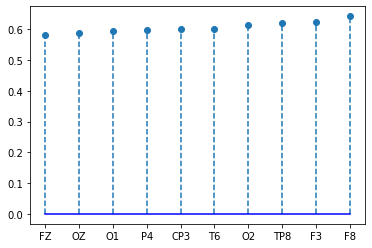

In [20]:
channel_names = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FT7', 'FC3', 'FCZ', 'FC4', 'FT8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'OZ', 'O2']

channel_weights_sorted, channel_names_sorted = zip(*sorted(zip(channel_weights, channel_names)))
channel_weights_10 = list(channel_weights_sorted)[len(channel_weights_sorted)-10:len(channel_weights_sorted)]
channel_names_10 = list(channel_names_sorted)[len(channel_names_sorted)-10:len(channel_names_sorted)]

plt.stem(channel_weights_10, label=channel_names_10, linefmt="--", basefmt="b")
plt.xticks(range(len(channel_names_10)), channel_names_10)
plt.show()